source: https://keras.io/examples/vision/edsr

In [ ]:
import os,shutil

from google.colab import drive
drive.mount('/content/drive')

#Imports

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

#Download the training dataset

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x2")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

#Flip, crop and resize images

In [4]:

def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

# hr_crop_size=96 , 144, 192
def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=2):
    """Crop images.

    for scale = 4
    low resolution images: 48x48
    hight resolution images: 192x192
    """
    lowres_crop_size = hr_crop_size // scale  # 192//4=48
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 48x48
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 192x192

    return lowres_img_cropped, highres_img_cropped


#Prepare a tf.Data.Dataset object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 48x48 RGB input patches.

In [5]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=2),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
        
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#Visualize the data

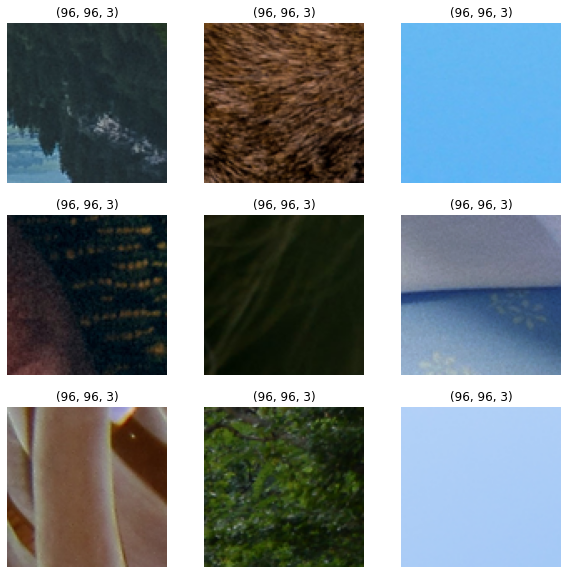

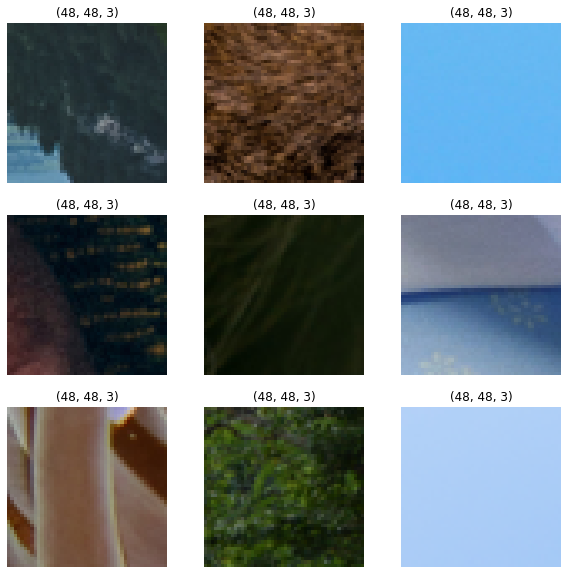

In [6]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


#Build the model

In [7]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs ):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same" ,**kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    #x = layers.Conv2D(64 * (factor ** 2), 3, padding="same" ,**kwargs)(x)
    #x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

#metrics

In [8]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)
    return psnr_value

#Train the model

In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR]) #losses.cauchy
# Training for more epochs will improve results
history_mae_x2 = model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

#save model

In [10]:
model.save('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/model_mae_x2.tf')

#save history

In [11]:
#source: https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

import pickle

with open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history_mae_x2', 'wb') as file_pi:
  pickle.dump(history_mae_x2.history, file_pi)

#compare training loss vs validation loss

In [12]:
#source: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

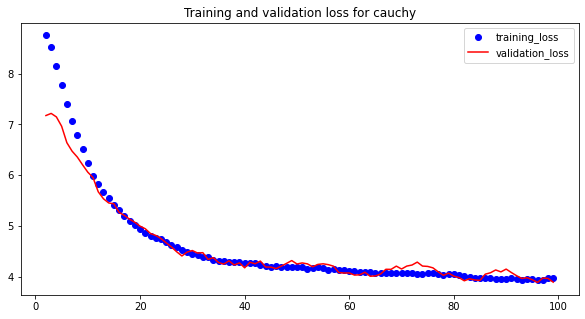

<Figure size 432x288 with 0 Axes>

In [13]:
import pickle
import matplotlib.pyplot as plt

history_mae_x2 = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history_mae_x2', "rb"))

epochs = range(2,len(history_mae_x2["loss"]))

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epochs, smooth_curve(history_mae_x2["loss"][2:]), 'bo', label='training_loss')  
ax.plot(epochs, smooth_curve(history_mae_x2["val_loss"][2:]), 'r', label='validation_loss')  

plt.title('Training and validation loss for cauchy')
plt.legend()

plt.figure()

plt.show()

#compare trainig psnr vs validation psnr

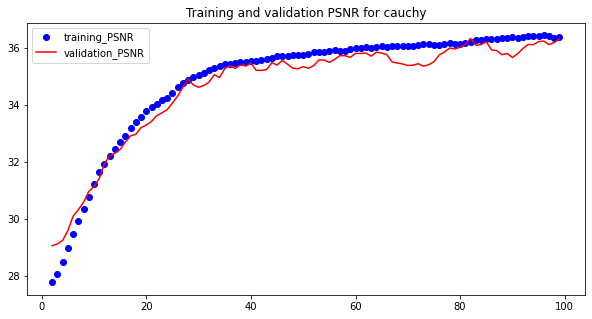

<Figure size 432x288 with 0 Axes>

In [14]:
import pickle
import matplotlib.pyplot as plt

history_mae_x2 = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history_mae_x2', "rb"))

epochs = range(2,len(history_mae_x2["PSNR"]))

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epochs, smooth_curve(history_mae_x2["PSNR"][2:]), 'bo', label='training_PSNR')  
ax.plot(epochs, smooth_curve(history_mae_x2["val_PSNR"][2:]), 'r', label='validation_PSNR')  

plt.title('Training and validation PSNR for cauchy')
plt.legend()

plt.figure()

plt.show()

#compare psnr histories

In [ ]:
#load history
import pickle
import matplotlib.pyplot as plt

history_tf_mae = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history_mae_x2', "rb"))
history_my_mae = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history_my_mae_x2', "rb"))

epochs = range(2,len(history_my_mae["val_PSNR"]))

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epochs, smooth_curve(history_tf_mae["val_PSNR"][2:]), label='tf_mae')  
ax.plot(epochs, smooth_curve(history_my_mae["val_PSNR"][2:]), label='my_mae')  

ax.set_xlabel('epochs')  
ax.set_ylabel('validation PSNR')  
ax.set_title("tf_mae vs. my_mae") 
ax.legend()

#load model

In [15]:
model = tf.keras.models.load_model('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/model_mae_x2.tf', custom_objects={'EDSRModel':EDSRModel, 'PSNR':PSNR}) #'my_mae':losses.my_mae

#Evaluate

#PSNR

In [16]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)
    return psnr_value

#calculate 1 - my ssim

In [ ]:
!pip install tensorflow-addons

In [18]:
import keras.backend as K
import tensorflow_addons as tfa
import math

def my_ssim(y_true, y_pred):

  #source: https://www.tensorflow.org/addons/api_docs/python/tfa/image/gaussian_filter2d
  #Means obtained by Gaussian filtering of inputs => source: https://www.programcreek.com/python/?CodeExample=compute+ssim
  #Sigma is a standard deviation of the gaussian

  y_true_mean = tfa.image.gaussian_filter2d(y_true, filter_shape=(11,11), sigma=1.5) #input and output is a Tensor
  y_pred_mean = tfa.image.gaussian_filter2d(y_pred, filter_shape=(11,11), sigma=1.5)

  #https://docs.w3cub.com/tensorflow~2.3/image/psnr
  #https://github.com/keras-team/keras/issues/1917
  #convert Tensorflow tensor to numpy
  y_true_mean = K.cast( y_true_mean, 'float32')/255
  y_pred_mean = K.cast( y_pred_mean, 'float32')/255

  y_true = K.cast( y_true, 'float32')/255
  y_pred = K.cast( y_pred, 'float32')/255

  #source: https://github.com/mubeta06/python/blob/master/signal_processing/sp/ssim.py
  # k1 & c1 depend on L (width of color map)
  l = 255
  k_1 = 0.01
  k_2 = 0.03
  c_1 = (k_1 * l)**2
  c_2 = (k_2 * l)**2

  # Squares of means
  mu_1_sq = y_true_mean**2
  mu_2_sq = y_pred_mean**2
  mu_1_mu_2 = y_true_mean * y_pred_mean

  sigma1_sq = (y_true - y_true_mean)**2
  sigma1_sq_mean = (tfa.image.mean_filter2d((y_true - y_true_mean)**2))**1/2
  sigma2_sq = (y_pred - y_pred_mean)**2 
  sigma2_sq_mean = (tfa.image.mean_filter2d((y_pred - y_pred_mean)**2))**1/2
  sigma12 = tfa.image.mean_filter2d((y_true - y_true_mean) * (y_pred - y_pred_mean))

  ssim_map = ((2 * mu_1_mu_2 + c_1)*(2 * sigma12 + c_2)) / ((mu_1_sq + mu_2_sq + c_1)*(sigma1_sq + sigma2_sq + c_2))
 
  # return MSSIM
  index = K.mean(ssim_map)

  return index

#calculate 2 - skimage.metrics import structural_similarity

In [22]:
from skimage.metrics import structural_similarity

def sk_ssim(y_true , y_pred):
  return structural_similarity(y_true , y_pred, guassian_weights=True , multichannel=True)


#calculate 3 - tf.image.ssim

In [31]:
from tensorflow.image import ssim

def tf_ssim(y_true , y_pred):
  return ssim(y_true , y_pred ,  max_val=255)

#calculate 4 - python downsample ssim

In [ ]:
!pip install git+https://github.com/olivesgatech/dippykit.git

from dippykit.metrics import SSIM as dsample_ssim

def downsample_ssim(y_true , y_pred):
  return dsample_ssim(y_true, y_pred, multichannel=True, auto_downsample = True, data_range=255.0)[0]

In [35]:
def plot_results(highres, lowres, preds):

  #convert Tensorflow tensor to numpy for psnr y channel
  preds_float = K.cast( preds, 'float32')
  highres_float = K.cast( highres, 'float32')

  plt.figure(figsize=(24, 14))
  plt.subplot(1,3,1), plt.imshow(highres), plt.title("high resolution")
  plt.subplot(1,3,2), plt.imshow(lowres), plt.title("low resolution")
  plt.subplot(1,3,3), plt.imshow(preds), plt.title("prediction(super resolution)"), plt.xlabel('PSNR y channel:{}\n my SSIM:{}\n sk_SSIM:{}\n tf SSIM:{}\n downsample SSIM:{}\n'.format( PSNR(tf.image.rgb_to_yuv(preds_float) , tf.image.rgb_to_yuv(highres_float)) , my_ssim(highres , preds) , sk_ssim(highres , preds) , tf_ssim(highres , preds) , downsample_ssim(highres , preds)))
  #plt.subplot(1,4,4), plt.imshow(highres - preds), plt.title("HR - SR")
  plt.show()

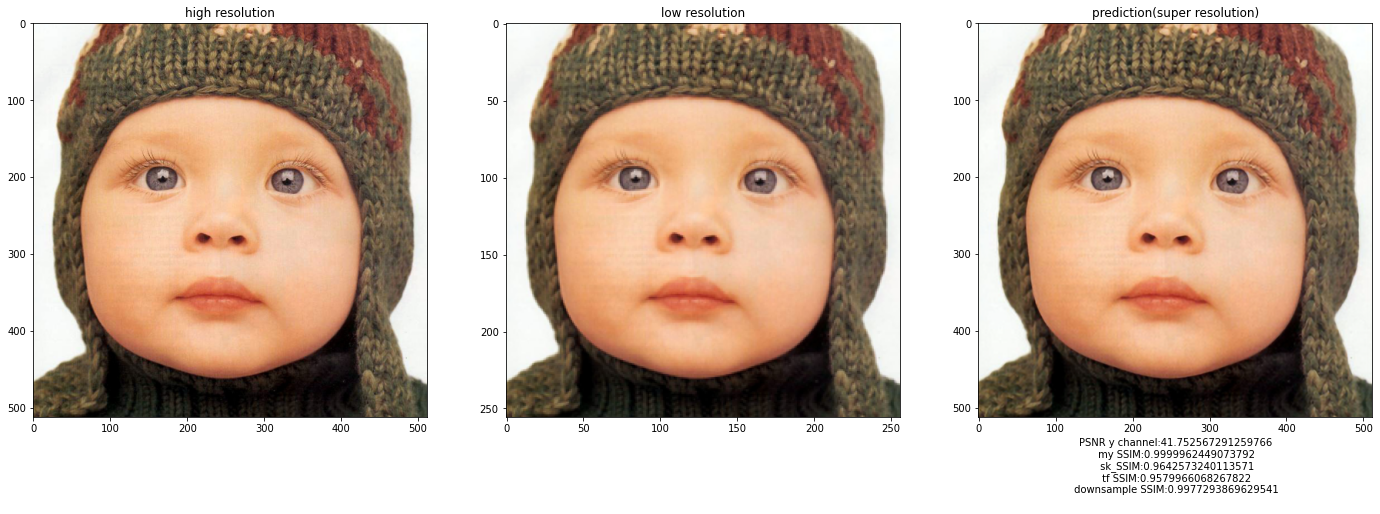

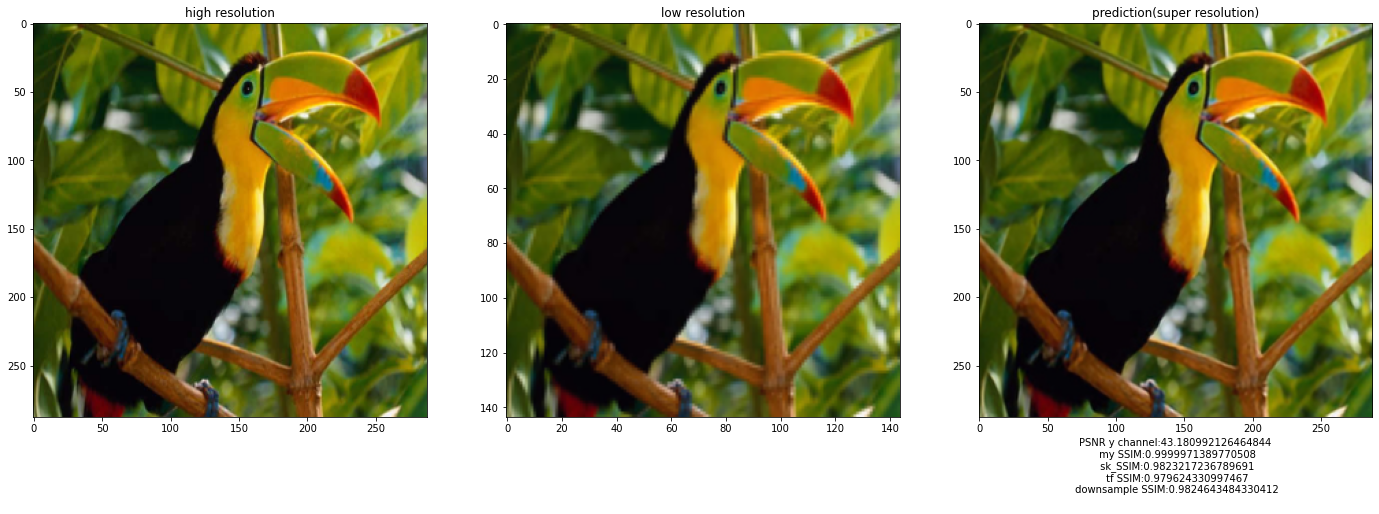

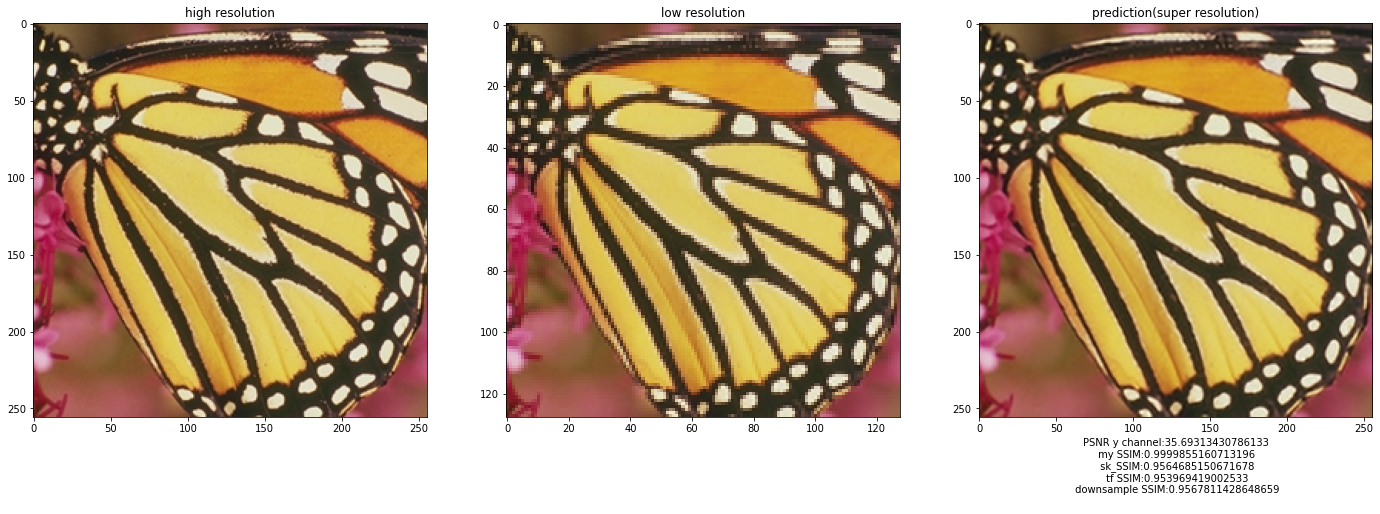

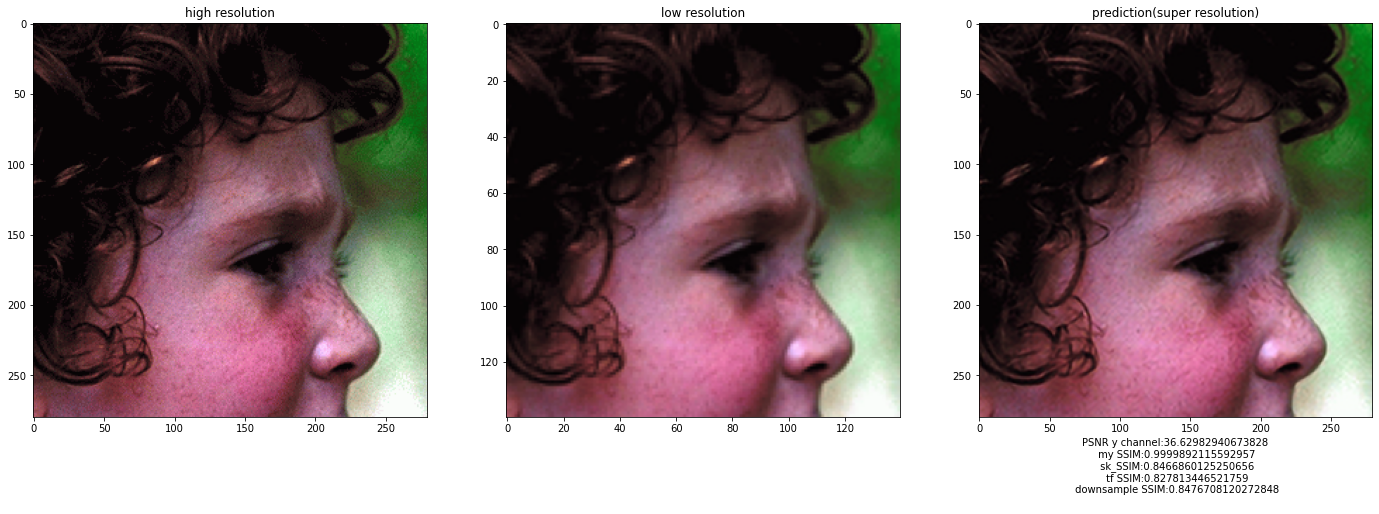

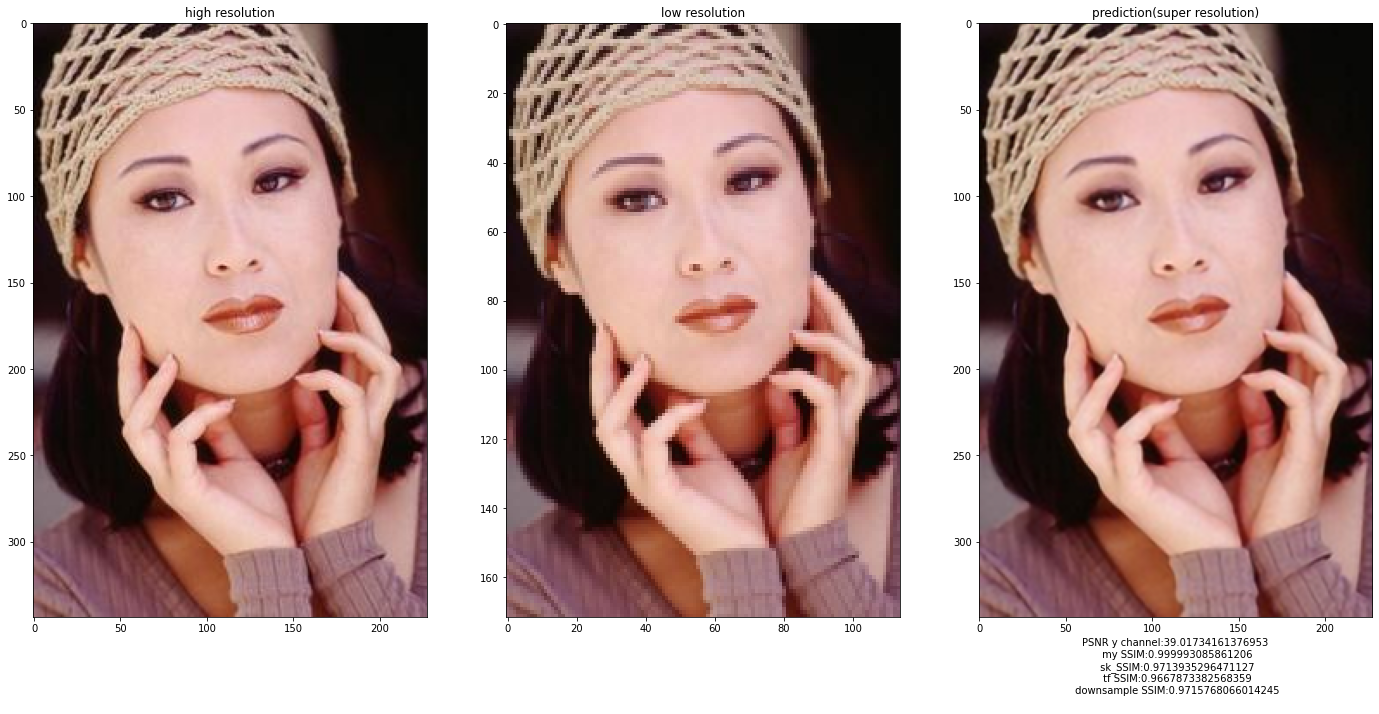


mean my SSIM: 0.9999921917915344

mean skimage SSIM: 0.9442254209859344

mean tensorflow SSIM: 0.9372382164001465

mean downsample SSIM: 0.9512444993779141

mean PSNR y channel: 39.2547721862793


In [39]:
import cv2
from glob import glob
import keras.backend as K

##just added for eagertensor to numpy error#
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


#PSNR_scores = []
my_SSIM_scores = []
sk_SSIM_scores = []
tf_SSIM_scores = []
downsample_SSIM_scores = []
PSNR_y_scores = []

#source: https://stackoverflow.com/questions/74319305/creating-a-custom-image-dataset-for-super-resolution

# define the paths to the dataset
# [Set5 , Set14 , BSDS100 , Urban100 , DIV2K/DIV2K_valid_HR]
BASE_DATA_PATH = './drive/MyDrive/datasets/Set5'
HR_test_path = os.path.join(BASE_DATA_PATH )
# [LRbicx2 , LRbicx3 , LRbicx4 , DIV2K_valid_LR_bicubic/LRbicx2]
LR_test_path = os.path.join(BASE_DATA_PATH, 'LRbicx2')

# create LR and HR image lists
LR_images = glob(LR_test_path + '/*.png')
HR_images = glob(HR_test_path + '/*.png')

# sort the lists
LR_images.sort()
HR_images.sort()

scale = 2

for i in range(len(HR_images)):

  #preprocess images
  LR_image = cv2.cvtColor(cv2.imread(LR_images[i]), cv2.COLOR_BGR2RGB)
  HR_image = cv2.cvtColor(cv2.imread(HR_images[i]), cv2.COLOR_BGR2RGB)
  
  #highres and preds must have the same size
  #so change the dims of highres (highres = LR_image*scale) 
  #print("LR image shape:",tf.shape(LR_image))
  #print("HR image shape (Before):", tf.shape(HR_image))

  #Note:
  #shape(height,width)
  #resize(width,height)
  if(int(tf.shape(LR_image)[0]*scale) == int(tf.shape(HR_image)[0])):
    #print("no")
    HR_image = cv2.resize(HR_image, ( int(tf.shape(LR_image)[1]*scale) , int(tf.shape(HR_image)[0]) ))
    #print("HR image shape(After):", tf.shape(HR_image))

  if(int(tf.shape(LR_image)[1]*scale) == int(tf.shape(HR_image)[1])):
    #print("yes")
    HR_image = cv2.resize(HR_image, ( int(tf.shape(HR_image)[1]) , int(tf.shape(LR_image)[0]*scale) ))
    #print("HR image shape(After):", tf.shape(HR_image))
  
  else:
    HR_image = cv2.resize(HR_image, (int(tf.shape(LR_image)[1]*scale), int(tf.shape(LR_image)[0]*scale) ))
    #print("HR image shape(After):", tf.shape(HR_image))

  #lowres = tf.image.random_crop(LR_image, (150, 150, 3))

  #prediction
  preds = model.predict_step(LR_image)
  #print("preds image shape:", tf.shape(preds))
  #print("****************************************")
  plot_results(HR_image,LR_image,preds)
  
  #image quality calculations on RGB Channel 
  #PSNR_scores.append(PSNR(preds, HR_image))

  #(Note: the ssim does not perform any colorspace transform.)
  #SSIM_scores.append(tf.image.ssim(preds, HR_image , max_val=255))
  
  #SSIM Index with automatic downsampling
  #matlab references: https://ece.uwaterloo.ca/~z70wang/research/ssim/   ,   https://github.com/josejuansanchez/ssim/blob/master/ssim.m
  #python reference: https://dippykit.github.io/dippykit/dippykit.metrics.html
  my_SSIM_scores.append(my_ssim(HR_image, preds))
  sk_SSIM_scores.append(sk_ssim(HR_image, preds))
  tf_SSIM_scores.append(tf_ssim(HR_image, preds))
  downsample_SSIM_scores.append(downsample_ssim(HR_image, preds))
  #print(my_SSIM_scores[i])

  #image quality calculations on Y Channel
  #convert Tensorflow tensor to numpy
  preds = K.cast( preds, 'float32')
  HR_image = K.cast( HR_image, 'float32')

  PSNR_y_scores.append(PSNR(tf.image.rgb_to_yuv(preds) , tf.image.rgb_to_yuv(HR_image)))

  #save sr images
  #preds = np.array(preds)
  #cv2.imwrite('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/sr{}.png'.format(i) , cv2.cvtColor(preds, cv2.COLOR_RGB2BGR))

  #HR_image = np.array(HR_image)
  #cv2.imwrite('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/hr{}.png'.format(i) , cv2.cvtColor(HR_image, cv2.COLOR_RGB2BGR))


#print("\nmean RGB PSNR on Set5 Validation set: {}".format(np.mean(PSNR_scores)))
print("\nmean my SSIM: {}".format(np.mean(my_SSIM_scores)))
print("\nmean skimage SSIM: {}".format(np.mean(sk_SSIM_scores)))
print("\nmean tensorflow SSIM: {}".format(np.mean(tf_SSIM_scores)))
print("\nmean downsample SSIM: {}".format(np.mean(downsample_SSIM_scores)))
print("\nmean PSNR y channel: {}".format(np.mean(PSNR_y_scores)))

#reasons for difference with paper results: https://github.com/krasserm/super-resolution/issues/19